# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 6
# Reg-Logistic Regression, ROC, and Data Imputation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import Imputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline

## Automated Breast Cancer Detection

In this homework, we will consider the problem of early breast cancer detection from X-ray images. Specifically, given a candidate region of interest (ROI) from an X-ray image of a patient's breast, the goal is to predict if the region corresponds to a malignant tumor (label 1) or is normal (label 0). The training and test data sets for this problem is provided in the file `hw6_dataset.csv`. Each row in these files corresponds to a ROI in a patient's X-ray, with columns 1-117 containing features computed using standard image processing algorithms. The last column contains the class label, and is based on a radiologist's opinion or a biopsy. This data was obtained from the KDD Cup 2008 challenge.

The data set contain a total of 69,098 candidate ROIs, of which only 409 are malignant, while the remaining are all normal. 

*Note*: be careful of reading/treating column names and row names in this data set.

## Question 1: Beyond Classification Accuracy


0.  Split the data set into a training set and a testing set.  The training set should be 75% of the original data set, and the testing set 25%.  Use `np.random.seed(9001)`.

1. Fit a logistic regression classifier to the training set and report the  accuracy of the classifier on the test set. You should use $L_2$ regularization in logistic regression, with the regularization parameter tuned using cross-validation. 
    1. How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients? 
    2. Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not?
    
For applications with imbalanced class labels, in this case when there are many more healthy subjects ($Y=0$) than those with cancer ($Y=1$), the classification accuracy may not be the best metric to evaluate a classifier's performance. As an alternative, we could analyze the confusion table for the classifier. 

<ol start="3">
<li> Compute the confusion table for both the fitted classifier and the classifier that predicts all 0's.</li>
<li> Using the entries of the confusion table compute the *true positive rate* and the *true negative rate* for the two classifiers. Explain what these evaluation metrics mean for the specific task of cancer detection. Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.</li>
<li> What is the *false positive rate* of the fitted classifier, and how is it related to its true positive and true negative rate? Why is a classifier with high false positive rate undesirable for a cancer detection task?</li>
</ol>
*Hint:* You may use the `metrics.confusion_matrix` function to compute the confusion matrix for a classification model.

First we read in the data and split it into a training set and a testing set.  The training set will be 75% of the original data set, and the testing set 25%.

In [2]:
def create_dataframe(file_path, header=None, usecols=None):
    col_names = ['X_' + str(i) for i in range(117)] + ['Y']
    data = pd.read_csv(file_path, header=header, names=col_names,
                       usecols=usecols)
    data['Y'] = data.Y.astype('int64')
    return data

In [3]:
# Download from https://canvas.harvard.edu/courses/29726/assignments/175288
breast_cancer = create_dataframe('../hwassets/data/HW6_dataset.csv')
breast_cancer.head()

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_108,X_109,X_110,X_111,X_112,X_113,X_114,X_115,X_116,Y
0,-0.144,-0.143,-0.1160,-0.1030,0.226,0.210,-0.9800,-0.780,-0.474,-0.447,...,0.925,0.516,0.34400,0.906,-1.1300,-0.552,0.553,-0.417,0.2560,0
1,-0.011,0.138,-0.2230,-0.1730,0.188,0.284,-0.0522,-0.256,0.129,0.427,...,-0.593,0.452,0.00785,-0.533,-0.0789,0.705,0.906,0.216,-0.0723,0
2,0.212,-0.313,0.2660,0.2320,-1.190,-1.150,-1.8100,-1.560,-1.250,-1.200,...,-0.816,1.570,0.39400,1.340,-1.1800,-2.700,-0.926,-2.650,-0.0447,0
3,0.215,-0.184,0.0274,0.0494,0.443,0.463,-1.0500,-0.941,-0.531,-0.394,...,0.634,0.111,0.37100,0.859,-0.9930,-0.492,0.363,0.326,-0.0528,0
4,0.279,-0.197,0.1270,0.0973,-0.213,-0.150,-1.3200,-0.994,-1.110,-1.090,...,-0.640,0.485,0.29500,0.403,-1.1200,-0.343,0.468,-0.820,0.4350,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    breast_cancer.drop('Y', axis=1),
    breast_cancer.Y, test_size=0.25,
    random_state=np.random.seed(9001))

Let's fit a logistic regression classifier to the training set and look at the accuracy of the classifier on the test set. We will use $L_2$ regularization with the regularization parameter tuned using 5-fold cross-validation.

In [5]:
def test_accuracy(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [6]:
logit_CV = LogisticRegressionCV(cv=5, penalty='l2', scoring='accuracy',
                                random_state=np.random.seed(9001))
accuracy = test_accuracy(logit_CV, X_train, y_train, X_test, y_test)
print('Test accuracy = ', accuracy)

Test accuracy =  0.9958321273516643


We now compare the fitted model with a baseline classifier that predicts 'normal' (label 0) on all patients.

In [7]:
y_normal = np.zeros(y_test.shape[0])
accuracy = accuracy_score(y_test, y_normal)
print('Test accuracy = ', accuracy)

Test accuracy =  0.9946743849493488


We see that the difference in the classification accuracies is very small, approximately 0.001, which is not enough to declare logistic regression as a better classifier than the all 0's classifier. This is because almost all the examples in the test set are normal (i.e. belong to the negative class).

The confusion tables for the classifier are much better to analyze in a situation like this where we have highly imbalanced classes.

In [8]:
def conf_matrix_df(y_test, y_pred):
    conf_matrix = pd.DataFrame(
        data=metrics.confusion_matrix(y_test, y_pred),
        columns=['Predicted Y=0', 'Predicted Y=1'],
        index=['Observed Y=0', 'Observed Y=1'])
    predicted = conf_matrix.sum(axis=0)
    predicted.name = 'Predicted'
    conf_matrix = conf_matrix.append(predicted)
    observed = conf_matrix.sum(axis=1)
    observed.name = 'Observed'
    conf_matrix = pd.concat((conf_matrix, observed), axis=1)
    return conf_matrix

In [9]:
print('Logistic regression')
conf_matrix_logit = conf_matrix_df(y_test, logit_CV.predict(X_test))
conf_matrix_logit

Logistic regression


,Predicted Y=0,Predicted Y=1,Observed
Observed Y=0,17177,6,17183
Observed Y=1,66,26,92
Predicted,17243,32,17275


In [10]:
print('Normal')
conf_matrix_normal = conf_matrix_df(y_test, y_normal)
conf_matrix_normal

Normal


,Predicted Y=0,Predicted Y=1,Observed
Observed Y=0,17183,0,17183
Observed Y=1,92,0,92
Predicted,17275,0,17275


We will now compute the *true positive rate* and the *true negative rate* for the two classifiers. In cancer detection, the *true positive rate* is the fraction of people who are predicted to have cancer who actually have cancer and the *true negative rate* is the fraction of people who are predicted not to have cancer who don't have cancer.

In [11]:
def conf_matrix_rates(confusion_matrix_df, name=None):
    true_positive_rate = confusion_matrix_df.loc[
        'Observed Y=1', 'Predicted Y=1'] / confusion_matrix_df.loc[
        'Observed Y=1', 'Observed']
    true_negative_rate = confusion_matrix_df.loc[
        'Observed Y=0', 'Predicted Y=0'] / confusion_matrix_df.loc[
        'Observed Y=0', 'Observed']
    false_positive_rate = confusion_matrix_df.loc[
        'Observed Y=0', 'Predicted Y=1'] / confusion_matrix_df.loc[
        'Observed Y=0', 'Observed']
    false_negative_rate = confusion_matrix_df.loc[
        'Observed Y=1', 'Predicted Y=0'] / confusion_matrix_df.loc[
        'Observed Y=1', 'Observed']
    index = ['True Positive Rate', 'True Negative Rate',
             'False Positive Rate', 'False Negative Rate']
    return pd.Series([true_positive_rate, true_negative_rate,
                      false_positive_rate, false_negative_rate],
                     index=index, name=name)

In [12]:
conf_matrix_rates(conf_matrix_logit, 'Logistic Regression')[0:2]

True Positive Rate    0.282609
True Negative Rate    0.999651
Name: Logistic Regression, dtype: float64

In [13]:
conf_matrix_rates(conf_matrix_normal, 'Normal')[0:2]

True Positive Rate    0.0
True Negative Rate    1.0
Name: Normal, dtype: float64

We can see that the true negative rates are similar for both classiers. However, the true positive rate is much better for the logistic regression classifier than the normal classifier which of course never predicts any positive. Therefore, based on the observed metrics, the fitted logistic regression model is better than the all 0's classifier for cancer prediction.

Let's take a look at the false positive rate (FPR) of the fitted logistic regression classifier. It's actually 1- TNR where TNR is the true negative rate. We can see this from the definition:

1 - TNR = 1 - TN / (TN + FP) = FP / (TN + FP) = FPR

In [14]:
display(conf_matrix_rates(conf_matrix_logit, 'Logistic Regression')[2:3])
1. - conf_matrix_rates(conf_matrix_logit,
                       'Logistic Regression')['True Negative Rate']

False Positive Rate    0.000349
Name: Logistic Regression, dtype: float64

0.00034918233137404275

We see that the false positive rate is very low. This is good because a classifier with high false positive rate would be undesirable for a cancer detection task as too many false alarms would be raised. This would lead to unnecessary increased stress amongst patients and a surge in appointments to see cancer specialists. 

## Question 2: ROC Analysis

Another powerful diagnostic tool for class-imbalanced classification tasks is the Receiver Operating Characteristic (ROC) curve. Notice that the default logistic regression classifier in `sklearn` classifies a data point by thresholding the predicted class probability $\hat{P}(Y=1)$ at 0.5. By using a different threshold, we can adjust the trade-off between the true positive rate (TPR) and false positive rate (FPR) of the classifier. The ROC curve allows us to visualize this trade-off across all possible thresholds.


1. Display the ROC curve for the fitted classifier on the *test set*. In the same plot, also display the ROC curve for the all 0's classifier. How do the two curves compare?

2.  Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved. Based on your results, comment on how the threshold influences a classifier's FPR.
    - FPR = 0
    - FPR = 0.1
    - FPR = 0.5
    - FPR = 0.9
- Suppose a clinician told you that diagnosing a cancer patient as normal is *twice* as critical an error as diagnosing a normal patient as having cancer. Based on this information, what threshold would you recommend the clinician to use? What is the TPR and FPR of the classifier at this threshold? 

- Compute the area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier. How does the difference in the AUCs of the two classifiers compare with the difference between their classification accuracies in Question 1, Part 2(A)? 

*Hint:* You may use the `metrics.roc_curve` function to compute the ROC curve for a classification model and the `metrics.roc_auc_score` function to compute the AUC for the model.

Let's plot the ROC curves on the test set for the two classifiers.

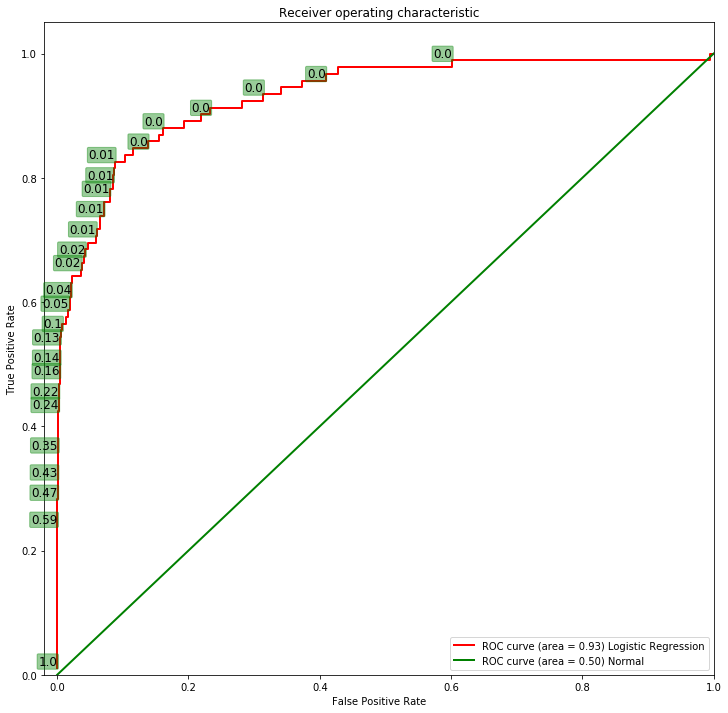

In [15]:
preds_logit = logit_CV.predict_proba(X_test)[:, 1]
fpr_logit, tpr_logit, thresholds_logit = metrics.roc_curve(
    y_test, preds_logit)
fpr_normal, tpr_normal, thresholds_normal = metrics.roc_curve(
    y_test, y_normal)

plt.figure(figsize=(12, 12))
lw = 2
roc_auc_logit = metrics.auc(fpr_logit, tpr_logit)
roc_auc_normal = metrics.auc(fpr_normal, tpr_normal)
plt.plot(fpr_logit, tpr_logit, color='red', lw=lw,
         label='ROC curve (area = %0.2f) Logistic Regression' % roc_auc_logit)
plt.plot(fpr_normal, tpr_normal, color='green',
         lw=lw, label='ROC curve (area = %0.2f) Normal' % roc_auc_normal)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
label_kwargs = {}
label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.1', alpha=0.4, color = 'green'
    )
for k in range(0, fpr_logit.shape[0], 5):
    threshold = str(np.round(thresholds_logit[k], 2))
    plt.annotate(threshold, (fpr_logit[k], tpr_logit[k]), **label_kwargs,
                 fontsize = 12, ha = 'right', va = 'bottom')
plt.show()

Looking at the curves, we see that when it comes to TPR and FPR the Normal model performs exactly as a flipping a fair coin would. Whereas, the performance of the Logistic Regression model is very good, with a high TRP and a low FPR through most classification thresholds.

Now suppose we wanted our FPR to be set at most at 0.3. What is the highest TPR we can get? What is the threshold at that point?

Let's now determine the TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved.
    - FPR = 0
    - FPR = 0.1
    - FPR = 0.5
    - FPR = 0.9

In [16]:
def print_highest_TPR(tpr, fpr, thresholds, fpr_threshold):
    print("Highest TPR with FPR set at {0}: {1}".format(
        fpr_threshold, tpr[np.min(
            [i for i, x in enumerate(fpr) if x >= fpr_threshold])]))
    print("Corresponding Threshold: {0}".format(
          thresholds[np.min(
              [i for i, x in enumerate(fpr) if x >= fpr_threshold])]))

In [17]:
print_highest_TPR(tpr_logit, fpr_logit, thresholds_logit, 0.)
print_highest_TPR(tpr_logit, fpr_logit, thresholds_logit, 0.1)
print_highest_TPR(tpr_logit, fpr_logit, thresholds_logit, 0.5)
print_highest_TPR(tpr_logit, fpr_logit, thresholds_logit, 0.9)

Highest TPR with FPR set at 0.0: 0.010869565217391304
Corresponding Threshold: 0.9983830190119585
Highest TPR with FPR set at 0.1: 0.8260869565217391
Corresponding Threshold: 0.006054414052125225
Highest TPR with FPR set at 0.5: 0.9782608695652174
Corresponding Threshold: 9.871110837364851e-05
Highest TPR with FPR set at 0.9: 0.9891304347826086
Corresponding Threshold: 4.4828965625691777e-10


Based on these results, we can see that as the threshold decreases, a classifier's FPR increases.

If a clinician told me that diagnosing a cancer patient as normal (false negative)  is *twice* as critical an error as diagnosing a normal patient as having cancer (false positive), I would recommend a threshold of 0.33 to use. To approximate, it will suffice to find the closest value in the `thresholds` array.

What is the TPR and FPR of the classifier at this threshold? 

In [18]:
# Hack: I know there is only 1 point here. In a production situation
# I would expect to use interpolation of some sort.
threshold_point = np.intersect1d(np.where(thresholds_logit >= 0.32),
                                 np.where(thresholds_logit <=0.34))[0] 
print('Threshold:', thresholds_logit[threshold_point])
print('FPR', fpr_logit[threshold_point])
print('TPR', tpr_logit[threshold_point])

Threshold: 0.32082916522857746
FPR 0.001280335215038119
TPR 0.40217391304347827


We can see the area under the ROC curve (AUC) for both the fitted Logistic regression classifier and the all 0's classifier in the ROC curve above. We see that the difference in the AUCs of the two classifiers is very large compared with the tiny difference between their classification accuracies in Question 1, Part 2(A). This is a clear indication that the AUC is a better metric than the classification accuracy in situations where there is a class imbalance in the labels.

## Question 3: Missing data

In this problem you are given a different data set, `hw6_dataset_missing.csv`, that is  similar to the one you used above (same column definitions and same conditions), however this data set contains missing values. 

*Note*: be careful of reading/treating column names and row names in this data set as well, it *may* be different than the first data set.


1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the regularized logistic regression as in Question 1 (use `LogisticRegressionCV` again to retune).  Report the overall classification rate and TPR in the test set.
2. Restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via mean imputation.  Split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
3. Again restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via a model-based imputation method. Once again split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
4. Compare the results in the 3 previous parts of this problem.  Prepare a paragraph (5-6 sentences) discussing the results, the computational complexity of the methods, and conjecture and explain why you get the results that you see.



First we read in the data, remove all observations containing missing values and split it into a training set and a testing set.  The training set will be 75% of the original data set, and the testing set 25%. Also, let's fit the regularized logistic regression model as before and look at the classification accuracy and TPR in the test set.

In [19]:
breast_cancer_missing = create_dataframe(
    '../hwassets/data/HW6_dataset_missing.csv', header=0,
    usecols=range(1, 119))
breast_cancer = breast_cancer_missing.dropna()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    breast_cancer.drop('Y', axis=1), breast_cancer.Y, test_size=0.25,
    random_state=np.random.seed(9001))

In [21]:
logit_CV = LogisticRegressionCV(cv=5, penalty='l2', scoring='accuracy',
                                random_state=np.random.seed(9001))
accuracy = test_accuracy(logit_CV, X_train, y_train, X_test, y_test)
print('Test accuracy = ', accuracy)
conf_matrix_rates(conf_matrix_df(y_test, logit_CV.predict(X_test)))[0:1]

c:\users\covuworie\.virtualenvs\a-2017-asnab769\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Test accuracy =  0.9972144846796658


True Positive Rate    0.0
dtype: float64

Let's restart with a fresh copy of the data in `hw6_dataset_missing.csv` and do the same again, but this time let's impute the missing data via mean imputation.

In [22]:
breast_cancer_mean_impute = breast_cancer_missing.copy()
mean_imputer = Imputer(strategy='mean')
breast_cancer_mean_impute = mean_imputer.fit_transform(
    breast_cancer_mean_impute.values)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    breast_cancer_mean_impute[:, :-1],
    breast_cancer_mean_impute[:, -1],
    test_size=0.25,
    random_state=np.random.seed(9001))

In [24]:
logit_CV = LogisticRegressionCV(cv=5, penalty='l2', scoring='accuracy',
                                random_state=np.random.seed(9001))
accuracy = test_accuracy(logit_CV, X_train, y_train, X_test, y_test)
print('Test accuracy for mean imputation = ', accuracy)
conf_matrix_rates(conf_matrix_df(y_test, logit_CV.predict(X_test)))[0:1]

Test accuracy for mean imputation =  0.99552


True Positive Rate    0.285714
dtype: float64

The third part of the question above which states to impute the missing data via a model-based imputation method does not make sense in this case as there are no missing values in the response variable. We show this now.

In [25]:
breast_cancer_missing.Y.isna().sum()

0

Compare the results from the 2 previous parts of this problem. The computational complexity of dropping the NA values is obviously less than that of imputing the mean. For model imputation the computational complexity would be far higher than both of these. The TPR is lower when we remove the NA values rather than impute the mean as most of the observations with NA values were associated with the positive class. 161 vs 3 to be precise which we can see below. Imputing the mean for NA is clearly better for model prediction as opposed to just dropping the observations with NA values which means there is less training data for fitting.

In [26]:
print('Number of Y=1 observations:', breast_cancer_missing.Y.sum())
print('Number of Y=1 observations without NA values:',
      breast_cancer_missing.dropna().Y.sum())

Number of Y=1 observations: 161
Number of Y=1 observations without NA values: 3


## APCOMP209a - Homework Question


This problem walks you through the derivation of the **likelihood equations** for a generalized linear model (GLM). Suppose that the random component of the GLM is in the univariate natural exponential family, so that
$$f(y_i|\theta_i) = h(y_i) e^{y_i\theta_i - b(\theta_i)}$$
Define the individual log-likelihood for each observation $i$ as
$$l_i(\theta_i) \equiv \log f(y_i|\theta_i)$$
with linear predictor
$$\eta_i = x_i^T\beta = g(\mu_i)$$
for some link function $g$ and where $\mu_i=E(Y_i)$.

1. Use the above expressions to write a simplified expression for the log-likelihood $l(\theta)$ for the entire dataset, $y_1, \dots, y_n$.

2. Use the chain rule to express $\frac{\partial l_i}{\partial \beta_j}$ in terms of the derivatives of $l_i, \theta_i, \mu_i$, and $\eta_i$. (*Hint*: Think carefully about which variables are related to which, and in what way. For example, for which of the above variables do you know the derivative with respect to $\beta_j$?)

3. Compute the derivatives for $\frac{\partial l_i}{\partial \theta_i}$ and $\frac{\partial \eta_i}{\partial \beta_j}$.

4. Express $\mu_i$ in terms of $\theta_i$, and use this relationship to compute $\frac{\partial \theta_i}{\partial \mu_i}$. (\emph{Hint}: Recall the cumulant function of a natural exponential family, and assume that you can write $\partial f/\partial g = (\partial g / \partial f)^{-1}$.)

5. Express $\eta_i$ in terms of $\mu_i$. Using the same hint as the above, compute $\frac{\partial \mu_i}{\partial \eta_i}$.

6. Put all of the above parts together to write an expression for $\frac{\partial l}{\partial \beta_j}$. Use matrix notation to write this expression as
$$\nabla_{\beta} l(\beta) = X^{T}DV^{-1}(Y - \mu) = 0$$
That is, compute the matrices $D$ and $V$ such that this equation holds.

7. If we use the canonical link function, how do your answers to part (6) simplify?

8. Finally, compute the above likelihood equations in the case of logistic regression, and show that this is equivalent to the solution given in lecture.


### Answers

1. $$\begin{align}
l(\theta) & = \log \prod_{i=1}^{n} l_{i}(\theta_{i}) \\
& = \log \prod_{i=1}^{n} f(y_i|\theta_i) \\ 
& = \log \prod_{i=1}^{n} h(y_i) e^{y_i\theta_i - b(\theta_i)} \\
& = \sum_{i=1}^{n} \log h(y_i) e^{y_i\theta_i - b(\theta_i)} \\ 
& = \sum_{i=1}^{n} \Big[\log h(y_i) + y_i\theta_i - b(\theta_i)\Big]
\end{align}$$

2. $$\frac{\partial l_{i}}{\partial \beta_{j}} = \frac{\partial l_{i}}{\partial \theta{i}} \frac{\partial \theta_{i}}{\partial \mu_{i}} \frac{\partial \mu_{i}}{\partial \eta_{i}} \frac{\partial \eta_{i}}{\partial \beta_{j}}$$

3. $$\frac{\partial l_{i}}{\partial \theta_{i}} = \frac{\partial log f(y_{i} \vert \theta_{i})}{\partial \theta_{i}} = y_{i} - b^{\prime}(\theta_{i}) = y_{i} - \mu_{i}$$ where the last equality is from the definition of the cumulant function (see part 4).

4. From the definition of the cumulant function (see Proposition 3.1 in [sec5.pdf](https://github.com/covuworie/a-2017/blob/master/Sections/advanced/sec5.pdf)) we have $\mu_{i} = b^{\prime}(\theta_{i})$. This implies
$\frac{\partial \mu_{i}}{\partial \theta_{i}} = \beta^{\prime \prime}(\theta_{i})$. Inverting we have:
$$\frac{\partial \theta_{i}}{\partial \mu_{i}} = \frac{1}{\beta^{\prime \prime}(\theta_{i})} = \frac{1}{var(y_{i} \vert \theta_{i})}$$ where the last equality is from the definition of the variance (see Theorem 3.2 in [sec5.pdf](https://github.com/covuworie/a-2017/blob/master/Sections/advanced/sec5.pdf)).

5. From the definition of the linear predictor above we have $\eta_{i} = x_{1}^{T}\beta = g(\mu_{i})$. This implies $\frac{\partial \eta_{i}}{\partial \mu_{i}} = g^{\prime}(\mu_{i})$. Inverting we have:
$$\frac{\partial \mu_{i}}{\partial \eta_{i}} = \frac{1}{g^{\prime}(\mu_{i})}$$

6. Substituting (3-5) into (2) and setting to zero yields:
$$\frac{\partial l_{i}}{\partial \beta_{j}} = x_{i}^{T} \frac{1}{g^{\prime}(\mu_{i})} \frac{1}{\beta^{\prime \prime}(\theta_{i})} (y_{i} - \mu_{i}) = 0$$ 
which in matrix form is identical to the matrix equation:
$$\nabla_{\beta} l(\beta) = X^{T}DV^{-1}(Y - \mu) = 0$$
where D is the diagonal matrix of terms and V is the diagonal matrix of variances in part 5 and part 4 above, respectively.

7. The canonical link function sets the natural parameter equal to the linear predictor:
$$ \theta \equiv x^{T} \beta \equiv \eta \equiv g(\mu)$$
In this case, the equation in 6 simplifies to:
$$\nabla_{\beta} l(\beta) = 0$$

8. For logistic regression we have:
$$y_{i} \vert \mu_{i} \sim Bern(\mu_{i})$$
and so the probability mass function can be written as:
$$ f(y_{i} \vert \mu_{i}) = \mu_{i}^{y_{i}}(1 - \mu_{i})^{1 - y_{i}} = \exp \Big[y_{i} \log\Big(\frac{\mu_{i}}{1 - \mu_{i}}\Big) + \log (1 - \mu_{i})\Big]$$
From this we see that:
$$\begin{align}
h(y_i) & = 1 \\
\theta_i & = logit(\mu_{i}) \equiv \log\Big(\frac{\mu_{i}}{1 - \mu_{i}}\Big) \equiv x_{i}^{T} \beta \\
b(\theta_i) & = - \log (1 - \mu_{i})
\end{align}$$
Inverting the $\theta_{i}$ equation above gives $\mu_{i} = logit^{-1}(x_{i}^{T} \beta) = \frac{\exp(x_{i}^{T} \beta)}{1 + \exp(x_{i}^{T} \beta)}$ (the logistic function) and substituting these into the expression in part 1 gives the log-likelihood for logistic regression:
$$l(\beta) = \sum_{i=1}^{n} \Big[y_{i} x_{i}^{T} \beta - \log \Big( 1 + \exp(x_{i}^{T} \beta) \Big) \Big]$$